In [1]:
from copy import deepcopy
from pathlib import Path
import json
import os
import pickle
import re
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import skimage
import seaborn as sns
import tifffile
import yaml
from einops import rearrange
from scipy.ndimage import binary_fill_holes, binary_erosion, binary_dilation
from sklearn.neighbors import NearestNeighbors

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.visualization.tiling_utils as tiling_utils
import mushroom.visualization.helpers as helpers

In [5]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1/')

In [6]:
os.listdir(project_dir)

['HT553P1-H2',
 'S18-25943-A7',
 'S18-5591-C8',
 'HT413C1-K2',
 'HT339B2-H1',
 'HT413C1-Th1k4A1',
 'kidney',
 'HT565B1-H2',
 'WD-76845',
 'analysis',
 'C3L-00970',
 'HT704B1',
 'C3L-00982',
 'HT225C1',
 'S18-9906',
 'HT268B1',
 'C3L-02551',
 'C3L-01287',
 'HT206B1',
 'HT448C1-Th1K1Fp1',
 'HT397B1']

## case-specific data generation

In [7]:
# case = 'HT704B1'

# dtype_to_channels = {
#     'xenium': ['EPCAM', 'KRT5', 'PTPRC', 'CD4', 'CD8A', 'MS4A1', 'CD68', 'CD163', 'ACTA2', 'PDPN', 'HLA-DQB2', 'LAG3', 'PDCD1', 'GZMB', 'PECAM1'],
#     'multiplex': [
#         'CD20',
#         'CD31',
#         'CD3e',
#         'CD4 (D)',
#         'CD68',
#         'CD8',
#         'CK14 (D)',
#         'E-cadherin',
#         'FOXP3',
#         'GATA3',
#         'GLUT1 (D)',
#         'Granzyme B',
#         'HLA-DR',
#         'Keratin 5',
#         'Ki67',
#         'MGP (D)',
#         'Pan-Cytokeratin',
#         'Podoplanin (D)',
#         'SMA (D)',
#     ],
#     'predicted_multiplex': [
#         'CD3e',
#         'CD68',
#         'HLA-DR',
#         'Keratin 5',
#         'Pan-Cytokeratin'
#     ],
# }

# dtype_to_thresholds = {
#     'multiplex': {
#         'epithelial': {
#             'channel': 'Pan-Cytokeratin',
#             'thresh': 40,
#         },
#         'myoepi': {
#             'channel': 'Keratin 5',
#             'thresh': 25,
#         },
#         'immune': {
#             'channel': 'HLA-DR',
#             'thresh': 40,
#         },
#         'background': {
#             'channel': None,
#             'thresh': 1.
#         }
#     },
#     'xenium': {
#         'epithelial': {
#             'channel': 'EPCAM',
#             'thresh': 10,
#         },
#         'myoepi': {
#             'channel': 'KRT5',
#             'thresh': 8,
#         },
#         'immune': {
#             'channel': 'HLA-DQB2',
#             'thresh': 30,
#         },
#         'background': {
#             'channel': None,
#             'thresh': 0.
#         }
#     },
# }

# dtype_to_thresholds['predicted_multiplex'] = dtype_to_thresholds['multiplex']

In [8]:
# case = 'HT206B1'

# dtype_to_channels = {
#     'xenium': ['EPCAM', 'PTPRC', 'CD4', 'CD8A', 'MS4A1', 'CD68', 'CD163', 'ACTA2', 'PDPN', 'HLA-DQB2', 'LAG3', 'PDCD1', 'GZMB', 'PECAM1'],
#     'multiplex': [
#         'CD163',
#         'CD20',
#         'CD31',
#         'CD4 (D)',
#         'CD45 (D)',
#         'CD8',
#         'CK14 (D)',
#         'E-cadherin',
#         'FOXP3',
#         'GATA3 (D)',
#         'HLA-DR',
#         'Keratin 5',
#         'Ki67',
#         'Pan-Cytokeratin',
#         'Podoplanin (D)',
#         'SMA (D)',
#         'Vimentin',
#     ],
#     'predicted_multiplex': [
#         'Pan-Cytokeratin',
#         'SMA (D)',
#         'CD31',
#         'CD68',
#         'HLA-DR',
#         'CD8'
#     ],
# }

# dtype_to_thresholds = {
#     'multiplex': {
#         'epithelial': {
#             'channel': 'Pan-Cytokeratin',
#             'thresh': 40,
#         },
#         'myoepi': {
#             'channel': 'SMA (D)',
#             'thresh': 40,
#         },
#         'immune': {
#             'channel': 'HLA-DR',
#             'thresh': 20,
#         },
#         'background': {
#             'channel': None,
#             'thresh': 1.
#         }
#     },
#     'xenium': {
#         'epithelial': {
#             'channel': 'EPCAM',
#             'thresh': 10,
#         },
#         'myoepi': {
#             'channel': 'ACTA2',
#             'thresh': 15,
#         },
#         'immune': {
#             'channel': 'HLA-DQB2',
#             'thresh': 25,
#         },
#         'background': {
#             'channel': None,
#             'thresh': 0.
#         }
#     },
# }
# dtype_to_thresholds['predicted_multiplex'] = dtype_to_thresholds['multiplex']

In [9]:
case = 'HT397B1'

dtype_to_channels = {
    'multiplex': [
        'CD31',
        'CD45 (D)',
        'CD8',
        'FoxP3',
        'GATA3 (D)',
        'GLUT1-(D)',
        'HLA-DR',
        'Keratin 14',
        'Ki67',
        'Pan-Cytokeratin',
        'Podoplanin',
        'SMA-(D)',
        'cKIT-(D)'
    ],
    'predicted_multiplex': [
        'CD8',
        'CD45 (D)',
        'HLA-DR',
        'Keratin 14',
        'Pan-Cytokeratin'
    ],
}

dtype_to_thresholds = {
    'multiplex': {
        'epithelial': {
            'channel': 'Pan-Cytokeratin',
            'thresh': 40,
        },
        'myoepi': {
            'channel': 'Keratin 14',
            'thresh': 8,
        },
        'immune': {
            'channel': 'HLA-DR',
            'thresh': 30,
        },
        'background': {
            'channel': None,
            'thresh': 1.
        }
    },

}
dtype_to_thresholds['predicted_multiplex'] = dtype_to_thresholds['multiplex']

In [10]:
tiling_resolution = 15

In [11]:
orig_config = yaml.safe_load(open(project_dir / case / 'mushroom_50res' / 'config.yaml'))
config = deepcopy(orig_config)
fps = sorted(utils.listfiles(project_dir / case / 'multiplex_prediction' / 'predictions', regex=r'ome.tif'))
for fp in fps:
    print(fp)
    sid = re.sub(r'^.*s[0-9]+_([^/]*[0-9]).ome.tif$', r'\1', fp)
    entry = [entry for entry in config['sections'] if entry['sid'] == sid][0]
    entry['data'][0] = {
        'dtype': 'predicted_multiplex',
        'filepath': fp
    }

config

/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s10_HT397B1-U28.ome.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s2_HT397B1-U4.ome.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s3_HT397B1-U8.ome.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s4_HT397B1-U11.ome.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s6_HT397B1-U16.ome.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/multiplex_prediction/predictions/s9_HT397B1-U20.ome.tif


{'dtype_specific_params': {'batch2_he': {'trainer_kwargs': {'steps_per_epoch': 1000}},
  'he': {'trainer_kwargs': {'steps_per_epoch': 1000}},
  'multiplex': {'trainer_kwargs': {'channel_mapping': {'AMACR': 'AMACR',
     'AMACR (D)': 'AMACR',
     'AMACR (Dnew)': 'AMACR',
     'AMACR (d)': 'AMACR',
     'AMACR(D)': 'AMACR',
     'AMACR(Dnew)': 'AMACR',
     'AMACR(d)': 'AMACR',
     'AMACR-(D)': 'AMACR',
     'AMACR-(Dnew)': 'AMACR',
     'AMACR-(d)': 'AMACR',
     'AQP1': 'AQP1',
     'AQP1 (D)': 'AQP1',
     'AQP1 (Dnew)': 'AQP1',
     'AQP1 (d)': 'AQP1',
     'AQP1(D)': 'AQP1',
     'AQP1(Dnew)': 'AQP1',
     'AQP1(d)': 'AQP1',
     'AQP1-(D)': 'AQP1',
     'AQP1-(Dnew)': 'AQP1',
     'AQP1-(d)': 'AQP1',
     'AQP2': 'AQP2',
     'AQP2 (D)': 'AQP2',
     'AQP2 (Dnew)': 'AQP2',
     'AQP2 (d)': 'AQP2',
     'AQP2(D)': 'AQP2',
     'AQP2(Dnew)': 'AQP2',
     'AQP2(d)': 'AQP2',
     'AQP2-(D)': 'AQP2',
     'AQP2-(Dnew)': 'AQP2',
     'AQP2-(d)': 'AQP2',
     'AR': 'AR',
     'AR (D)': 

In [12]:
sid_to_position = {entry['sid']:entry['position'] for entry in config['sections']}

In [13]:
fp = [entry['data'][0]['filepath'] for entry in config['sections']
      if entry['data'][0]['dtype']=='multiplex'][0]
size = multiplex.get_size(fp)[1:]
ppm = multiplex.pixels_per_micron(fp)
tiling_size = int(tiling_resolution * ppm)
target_size = [int(x // tiling_size) for x in size]
tiling_size, target_size

(34, [548, 540])

In [14]:
fps = [entry['data'][0]['filepath'] for entry in config['sections'] if entry['data'][0]['dtype']=='multiplex']
multiplex.get_common_channels(fps)

['Bap1 (D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

In [15]:
for dtype, channels in dtype_to_channels.items():
    fps = [entry['data'][0]['filepath'] for entry in config['sections'] if entry['data'][0]['dtype']==dtype]
    if channels == 'all':
        if 'multiplex' in dtype:
            dtype_to_channels[dtype] = multiplex.get_common_channels(fps)
        else:
            dtype_to_channels[dtype] = xenium.get_common_channels(fps)
dtype_to_channels

{'multiplex': ['CD31',
  'CD45 (D)',
  'CD8',
  'FoxP3',
  'GATA3 (D)',
  'GLUT1-(D)',
  'HLA-DR',
  'Keratin 14',
  'Ki67',
  'Pan-Cytokeratin',
  'Podoplanin',
  'SMA-(D)',
  'cKIT-(D)'],
 'predicted_multiplex': ['CD8',
  'CD45 (D)',
  'HLA-DR',
  'Keratin 14',
  'Pan-Cytokeratin']}

In [16]:
dtype_to_tiled = {}
for dtype, channels in dtype_to_channels.items():
    dtype_to_tiled[dtype] = tiling_utils.get_tiled_sections(
        config, dtype=dtype, channel_names=channels,
        tiling_size=tiling_size, target_size=target_size
    )
for dtype, tiled in dtype_to_tiled.items():
    print(dtype, tiled.shape)

multiplex (4, 13, 548, 540)
predicted_multiplex (6, 5, 548, 540)


In [17]:
dtype_to_masks = {}
for dtype, tiled in dtype_to_tiled.items():
    data = dtype_to_thresholds[dtype]['epithelial']
    channel, thresh = data['channel'], data['thresh']
    channel_idx = dtype_to_channels[dtype].index(channel)
    
    masks = helpers.to_masks(tiled[:, channel_idx], thresh)
    dtype_to_masks[dtype] = masks

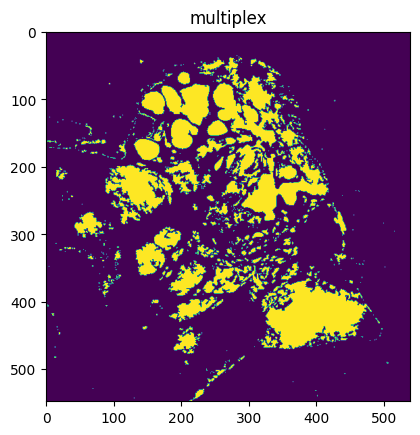

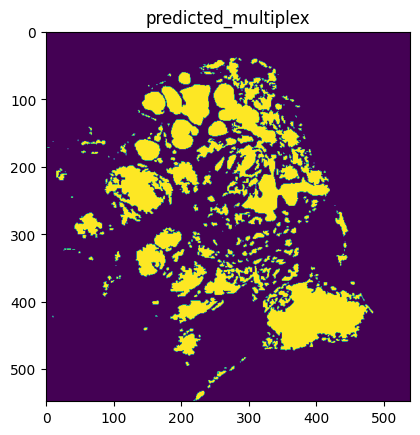

In [18]:
for dtype, masks in dtype_to_masks.items():
    plt.imshow(masks[0])
    plt.title(dtype)
    plt.show()

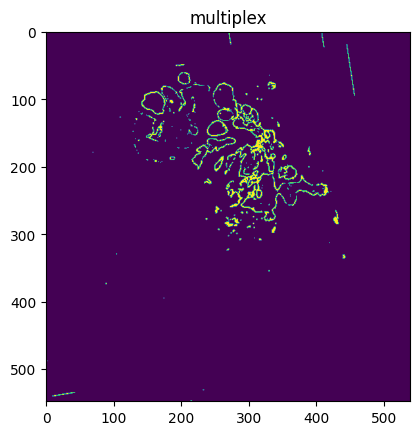

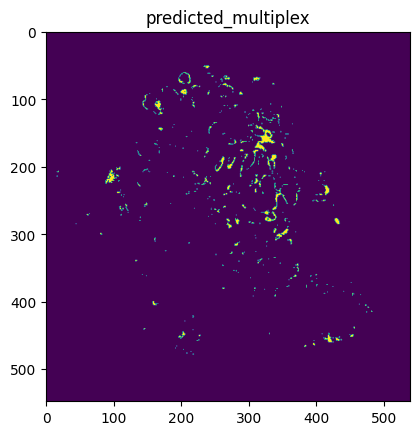

In [19]:
for dtype, tiled in dtype_to_tiled.items():
    data = dtype_to_thresholds[dtype]['myoepi']
    channel, thresh = data['channel'], data['thresh']
    channel_idx = dtype_to_channels[dtype].index(channel)
    
    plt.imshow(tiled[0, channel_idx] > thresh)
    plt.title(dtype)
    plt.show()

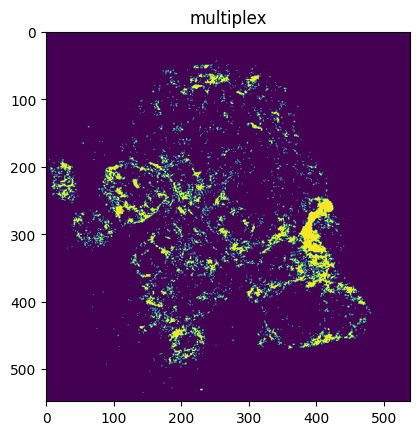

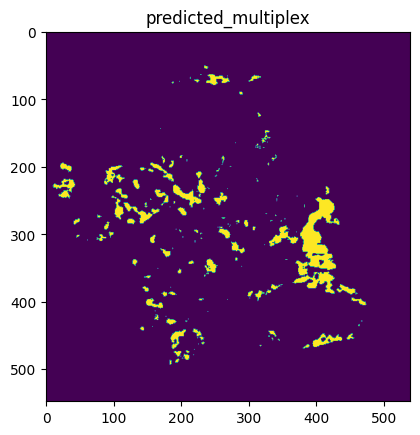

In [20]:
for dtype, tiled in dtype_to_tiled.items():
    data = dtype_to_thresholds[dtype]['immune']
    channel, thresh = data['channel'], data['thresh']
    channel_idx = dtype_to_channels[dtype].index(channel)
    
    plt.imshow(tiled[0, channel_idx] > thresh)
    plt.title(dtype)
    plt.show()

In [21]:
sid_to_mask, sid_to_tiled, sid_to_dtype = {}, {}, {}
for dtype in dtype_to_masks.keys():
    masks = dtype_to_masks[dtype]
    tiled = dtype_to_tiled[dtype]
    sids = [entry['sid'] for entry in config['sections'] if entry['data'][0]['dtype']==dtype]
    for sid, m, t in zip(sids, masks, tiled):
        sid_to_mask[sid] = m
        sid_to_tiled[sid] = t
        sid_to_dtype[sid] = dtype
sid_to_mask.keys()

dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31', 'HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28'])

In [22]:
sid_order = [entry['sid'] for entry in config['sections'] if entry['sid'] in sid_to_mask.keys()]
sid_order

['HT397B1-U2',
 'HT397B1-U4',
 'HT397B1-U8',
 'HT397B1-U11',
 'HT397B1-U12',
 'HT397B1-U16',
 'HT397B1-U22',
 'HT397B1-U20',
 'HT397B1-U28',
 'HT397B1-U31']

In [23]:
sid_to_labeled = {sid:skimage.morphology.label(m) for sid, m in sid_to_mask.items()}
sid_to_labeled.keys()

dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31', 'HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28'])

In [24]:
def is_channel_related(name):
    if any([
        re.match(r'^.*_external$', name),
        re.match(r'^.*_boundary$', name),
        re.match(r'^.*_region$', name),
    ]):
        return True
    return False

sid_to_props = {}
region_df = None
for sid in sid_order:
    print(sid)
    dtype = sid_to_dtype[sid]
    labeled = sid_to_labeled[sid]
    img = sid_to_tiled[sid]
    channels = dtype_to_channels[dtype]
    channel_info = dtype_to_thresholds[dtype]
    channel_info = {k:v for k, v in channel_info.items() if k != 'background'}
    df, props = helpers.quantify_labeled(
        labeled, img, channels, boundary_dist=1, external_dist=4, channel_info=channel_info)
    
    df['sid'] = sid
    df['dtype'] = dtype
    df['label'] = [p.label for p in props]
    df['section_index'] = sid_order.index(sid)
    df.index = [f'{sid}_{i}' for i, sid in zip(df.index, df['sid'])]
    df.columns = [f'{dtype}_{c}' if is_channel_related(c) else c for c in df.columns]
    
    if region_df is None:
        region_df = df
    else:
        region_df = pd.concat((region_df, df))
        
    sid_to_props[sid] = props
region_df

HT397B1-U2
HT397B1-U4
HT397B1-U8
HT397B1-U11
HT397B1-U12


/data/estorrs/mushroom/mushroom/visualization/helpers.py:75: RuntimeWarning: Mean of empty slice.
  boundary_means = region_img[:, mask_dict['boundary']].mean(-1)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/data/estorrs/mushroom/mushroom/visualization/helpers.py:76: RuntimeWarning: Mean of empty slice.
  internal_means = region_img[:, mask_dict['region']].mean(-1)
/data/estorrs/mushroom/mushroom/visualization/helpers.py:77: RuntimeWarning: Mean of empty slice.
  external_means = region_img[:, mask_dict['external']].mean(-1)


HT397B1-U16
HT397B1-U22
HT397B1-U20
HT397B1-U28


/data/estorrs/mushroom/mushroom/visualization/helpers.py:75: RuntimeWarning: Mean of empty slice.
  boundary_means = region_img[:, mask_dict['boundary']].mean(-1)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/data/estorrs/mushroom/mushroom/visualization/helpers.py:76: RuntimeWarning: Mean of empty slice.
  internal_means = region_img[:, mask_dict['region']].mean(-1)
/data/estorrs/mushroom/mushroom/visualization/helpers.py:77: RuntimeWarning: Mean of empty slice.
  external_means = region_img[:, mask_dict['external']].mean(-1)


HT397B1-U31


area   r1   r2   c1   c2  centroid_r  centroid_c  \
HT397B1-U2_0       1.0   32   41  278  287   36.000000  282.000000   
HT397B1-U2_1       1.0   34   43  281  290   38.000000  285.000000   
HT397B1-U2_2       3.0   35   45  250  260   39.666667  254.333333   
HT397B1-U2_3     194.0   35   66  260  288   49.608247  273.917526   
HT397B1-U2_4      14.0   35   48  281  294   41.142857  286.928571   
...                ...  ...  ...  ...  ...         ...         ...   
HT397B1-U31_642   23.0  526  540  222  236  532.652174  228.695652   
HT397B1-U31_643    1.0  531  540  190  199  535.000000  194.000000   
HT397B1-U31_644    1.0  532  541  123  132  536.000000  127.000000   
HT397B1-U31_645   22.0  539  547  146  161  545.318182  152.863636   
HT397B1-U31_646    9.0  540  547  160  172  545.888889  165.444444   

                 multiplex_CD31_boundary  multiplex_CD45 (D)_boundary  \
HT397B1-U2_0                    0.400000                     1.000000   
HT397B1-U2_1                    0.600000                     1.000000   
HT397B1-U2_2                    1.500000                     6.200000   
HT397B1-U2_3                    2.098684                     1.677632   
HT397B1-U2_4                    0.843750                     1.000000   
...                                  ...                          ...   
HT397B1-U31_642                 1.906250                     1.906250   
HT397B1-U31_643                 0.000000                     0.600000   
HT397B1-U31_644                 0.000000                     0.400000   
HT397B1-U31_645                 0.280000                     1.000000   
HT397B1-U31_646                 0.571429                     1.714286   

                 multiplex_CD8_boundary  ...  predicted_multiplex_CD8_region  \
HT397B1-U2_0                    1.00000  ...                             NaN   
HT397B1-U2_1                    1.00000  ...                             NaN   
HT397B1-U2_2                    0.30000  ...                             NaN   
HT397B1-U2_3                    0.50000  ...                             NaN   
HT397B1-U2_4                    1.00000  ...                             NaN   
...                                 ...  ...                             ...   
HT397B1-U31_642                 0.03125  ...                             NaN   
HT397B1-U31_643                 0.00000  ...                             NaN   
HT397B1-U31_644                 0.00000  ...                             NaN   
HT397B1-U31_645                 0.04000  ...                             NaN   
HT397B1-U31_646                 0.00000  ...                             NaN   

                 predicted_multiplex_CD45 (D)_region  \
HT397B1-U2_0                                     NaN   
HT397B1-U2_1                                     NaN   
HT397B1-U2_2                                     NaN   
HT397B1-U2_3                                     NaN   
HT397B1-U2_4                                     NaN   
...                                              ...   
HT397B1-U31_642                                  NaN   
HT397B1-U31_643                                  NaN   
HT397B1-U31_644                                  NaN   
HT397B1-U31_645                                  NaN   
HT397B1-U31_646                                  NaN   

                 predicted_multiplex_HLA-DR_region  \
HT397B1-U2_0                                   NaN   
HT397B1-U2_1                                   NaN   
HT397B1-U2_2                                   NaN   
HT397B1-U2_3                                   NaN   
HT397B1-U2_4                                   NaN   
...                                            ...   
HT397B1-U31_642                                NaN   
HT397B1-U31_643                                NaN   
HT397B1-U31_644                                NaN   
HT397B1-U31_645                                NaN   
HT397B1-U31_646                                NaN   

                 

In [25]:
dtype_to_channels.keys()

dict_keys(['multiplex', 'predicted_multiplex'])

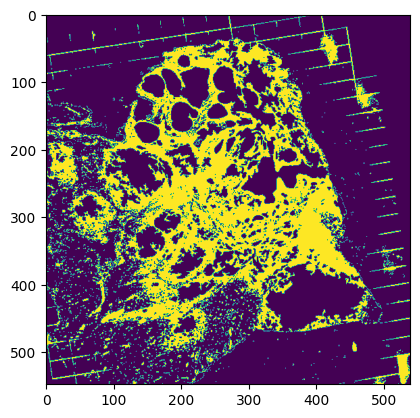

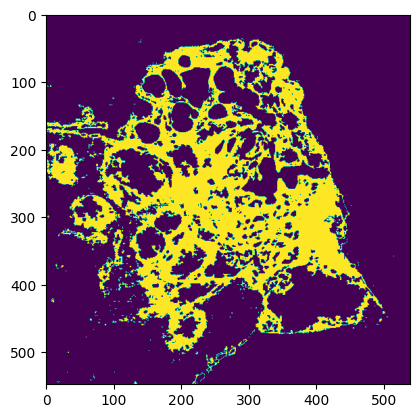

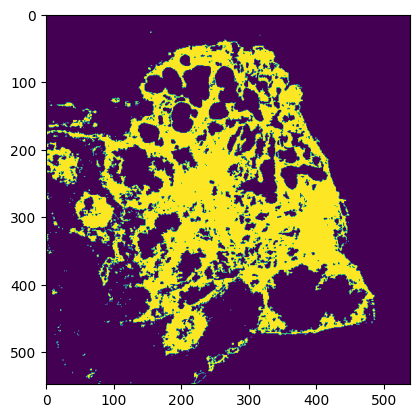

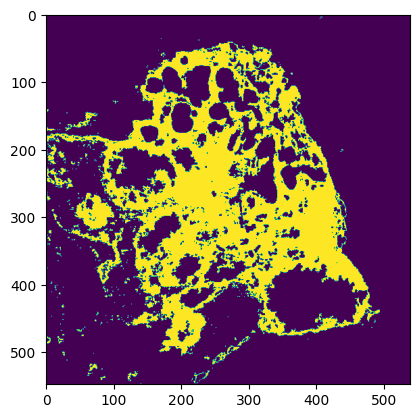

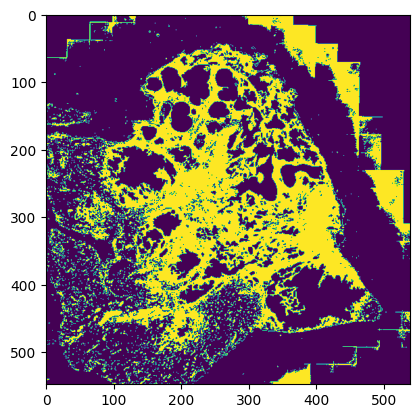

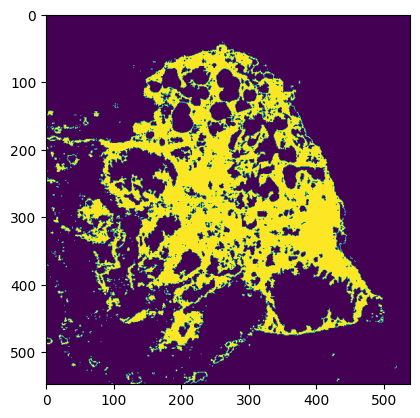

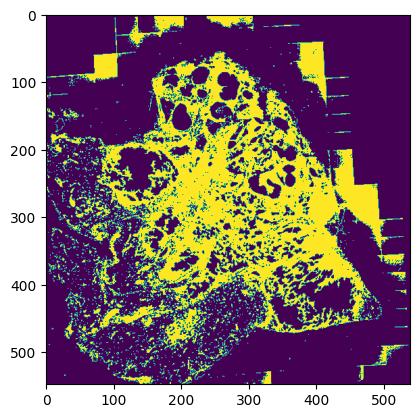

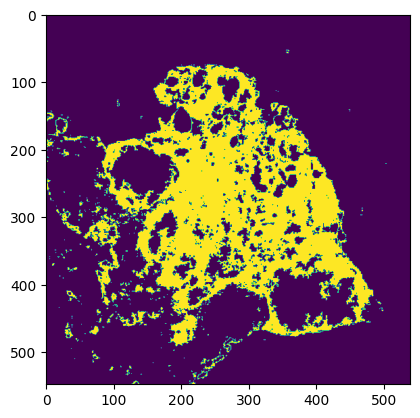

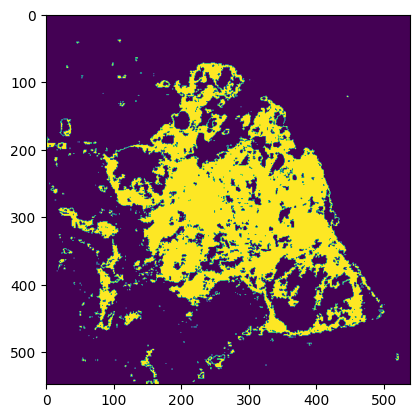

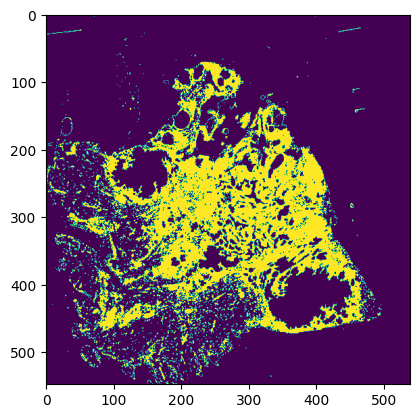

((384622, 3), (771714, 3))

In [26]:
sid_indices = []
tumor_pts, tme_pts = [], []
for i, sid in enumerate(sid_order):
    tiled = sid_to_tiled[sid]
    labeled = sid_to_labeled[sid]
    
    thresh = dtype_to_thresholds[sid_to_dtype[sid]]['background']['thresh']
    tissue_mask = tiled.mean(0) <= thresh
    z = sid_to_position[sid] / tiling_resolution
    hs, ws = np.where(labeled > 0)
    tumor_pts.append(rearrange(np.stack([[z] * len(hs), hs, ws]), 'd n -> n d'))
    
    plt.imshow((labeled == 0) & ~tissue_mask)
    plt.show()
    hs, ws = np.where((labeled == 0) & ~tissue_mask)
    tme_pts.append(rearrange(np.stack([[z] * len(hs), hs, ws]), 'd n -> n d'))
    
    sid_indices += [i] * len(hs)
sid_indices = np.asarray(sid_indices)
tumor_pts = np.concatenate(tumor_pts)
tme_pts = np.concatenate(tme_pts)
tumor_pts.shape, tme_pts.shape

In [27]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(tumor_pts)
distances, idxs = nn.kneighbors(tme_pts)
distances.shape, idxs.shape

((771714, 1), (771714, 1))

In [28]:
tme_distance_df = None
for i, sid in enumerate(sid_order):
    dtype = sid_to_dtype[sid]
    mask = sid_indices == i
    pts = tme_pts[mask].astype(int)
    dists = distances[mask]
    
    tiled = sid_to_tiled[sid].astype(np.float32)
    tiled -= tiled.min((-2, -1), keepdims=True)
    tiled /= tiled.std((-2, -1), keepdims=True)
    
    vals = tiled[:, pts[:, 1], pts[:, 2]]
    df = pd.DataFrame(data=vals.T, columns=dtype_to_channels[dtype])
    df.columns = [f'{dtype}_{c}_intensity' for c in df.columns]
    df['sid'] = sid
    df['distance'] = dists
    
    if tme_distance_df is None:
        tme_distance_df = df
    else:
        tme_distance_df = pd.concat((tme_distance_df, df))
tme_distance_df.index = np.arange(tme_distance_df.shape[0])

bins = np.linspace(0, tme_distance_df['distance'].max(), int(tme_distance_df['distance'].max()))
tme_distance_df['distance_bin'] = np.digitize(tme_distance_df['distance'], bins=bins)
tme_distance_df['distance_bin'][tme_distance_df['distance_bin']>10] = 10

tme_distance_df

/tmp/ipykernel_2852167/866989414.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tme_distance_df['distance_bin'][tme_distance_df['distance_bin']>10] = 10


multiplex_CD31_intensity  multiplex_CD45 (D)_intensity  \
0                       0.000000                      0.355096   
1                       0.000000                      0.710192   
2                       1.222022                      2.840769   
3                       0.000000                      0.000000   
4                       0.000000                      0.000000   
...                          ...                           ...   
771709                  0.000000                      0.514321   
771710                  0.000000                      0.771481   
771711                  0.904434                      0.000000   
771712                  0.602956                      0.000000   
771713                  0.000000                      0.000000   

        multiplex_CD8_intensity  multiplex_FoxP3_intensity  \
0                      0.692124                   0.000000   
1                      2.076372                   0.922397   
2                      8.997614                  11.991165   
3                      2.076372                   0.000000   
4                      2.076372                   0.000000   
...                         ...                        ...   
771709                 0.000000                   0.000000   
771710                 0.000000                   0.000000   
771711                 0.000000                   0.000000   
771712                 0.000000                   0.000000   
771713                 0.000000                   0.000000   

        multiplex_GATA3 (D)_intensity  multiplex_GLUT1-(D)_intensity  \
0                            0.030534                       0.284570   
1                            0.091601                       0.379427   
2                            0.396936                       1.138280   
3                            0.061067                       0.189713   
4                            0.061067                       0.284570   
...                               ...                            ...   
771709                       0.103526                       0.854137   
771710                       0.207053                       1.328657   
771711                       0.000000                       0.949041   
771712                       0.000000                       0.759233   
771713                       0.000000                       1.708274   

        multiplex_HLA-DR_intensity  multiplex_Keratin 14_intensity  \
0                         0.115942                        0.230310   
1                         0.173912                        0.230310   
2                         0.927532                        2.187943   
3                         0.115942                        0.000000   
4                         0.115942                        0.000000   
...                            ...                             ...   
771709                    0.172806                        0.205110   
771710                    0.259209                        0.205110   
771711                    0.000000                        0.205110   
771712                    0.000000                        0.205110   
771713                    0.000000                        0.205110   

        multiplex_Ki67_intensity  multiplex_Pan-Cytokeratin_intensity  ...  \
0                       0.200397                             0.016663  ...   
1                       0.400794                             0.033326  ...   
2                       3.406751                             0.183291  ...   
3                       0.000000                             0.033326  ...   
4                       0.000000                             0.033326  ...   
...                          ...                                  ...  ...   
771709                  0.000000                             0.055096  ...   
771710                  0.000000                             0.055096  ...   
771711                  0.000000                             0

In [30]:
# idxs = np.random.choice(np.arange(tme_distance_df.shape[0]), size=100000, replace=False)
# sns.lineplot(data=tme_distance_df.iloc[idxs], x='distance_bin', y='xenium_CD68_intensity')

In [31]:
list(region_df.columns)

['area',
 'r1',
 'r2',
 'c1',
 'c2',
 'centroid_r',
 'centroid_c',
 'multiplex_CD31_boundary',
 'multiplex_CD45 (D)_boundary',
 'multiplex_CD8_boundary',
 'multiplex_FoxP3_boundary',
 'multiplex_GATA3 (D)_boundary',
 'multiplex_GLUT1-(D)_boundary',
 'multiplex_HLA-DR_boundary',
 'multiplex_Keratin 14_boundary',
 'multiplex_Ki67_boundary',
 'multiplex_Pan-Cytokeratin_boundary',
 'multiplex_Podoplanin_boundary',
 'multiplex_SMA-(D)_boundary',
 'multiplex_cKIT-(D)_boundary',
 'multiplex_CD31_region',
 'multiplex_CD45 (D)_region',
 'multiplex_CD8_region',
 'multiplex_FoxP3_region',
 'multiplex_GATA3 (D)_region',
 'multiplex_GLUT1-(D)_region',
 'multiplex_HLA-DR_region',
 'multiplex_Keratin 14_region',
 'multiplex_Ki67_region',
 'multiplex_Pan-Cytokeratin_region',
 'multiplex_Podoplanin_region',
 'multiplex_SMA-(D)_region',
 'multiplex_cKIT-(D)_region',
 'multiplex_CD31_external',
 'multiplex_CD45 (D)_external',
 'multiplex_CD8_external',
 'multiplex_FoxP3_external',
 'multiplex_GATA3 (D)_e

In [32]:
output_dir = project_dir / case / 'region_analysis'
output_dir.mkdir(parents=True, exist_ok=True)

In [33]:
region_df.index.name = 'region_id'
region_df.to_csv(output_dir / 'regions.txt', sep='\t')

tme_distance_df.index.name = 'id'
tme_distance_df.to_csv(output_dir / 'tme_distances.txt', sep='\t')

pickle.dump({
    'dtype_to_channels': dtype_to_channels,
    'dtype_to_thresholds': dtype_to_thresholds,
    'dtype_to_masks': dtype_to_masks,
    'dtype_to_tiled': dtype_to_tiled,
    'sid_order': sid_order,
    'sid_to_dtype': sid_to_dtype,
    'sid_to_position': sid_to_position,
    'sid_to_labeled': sid_to_labeled,
    'sid_to_mask': sid_to_mask,
    'sid_to_tiled': sid_to_tiled,
}, open(output_dir / 'data.pkl', 'wb'), protocol=4)


## Combined analysis

In [22]:
tiling_resolution = 15
cases = [
    'HT704B1',
    'HT206B1',
    'HT397B1',
]

case_to_data = {}
for case in cases:
    data = pickle.load(open(project_dir / case / 'region_analysis' / 'data.pkl', 'rb'))
    data['regions'] = pd.read_csv(project_dir / case / 'region_analysis' / 'regions.txt',
                                  sep='\t', index_col='region_id')
    data['tme_distances'] = pd.read_csv(project_dir / case / 'region_analysis' / 'tme_distances.txt',
                                  sep='\t', index_col=0)
    data['sid_to_props'] = {sid:skimage.measure.regionprops(x) for sid, x in data['sid_to_labeled'].items()}
    data['config'] = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    case_to_data[case] = data
case_to_data.keys(), next(iter(case_to_data.values())).keys()

(dict_keys(['HT704B1', 'HT206B1', 'HT397B1']),
 dict_keys(['dtype_to_channels', 'dtype_to_thresholds', 'dtype_to_masks', 'dtype_to_tiled', 'sid_order', 'sid_to_dtype', 'sid_to_position', 'sid_to_labeled', 'sid_to_mask', 'sid_to_tiled', 'regions', 'tme_distances', 'sid_to_props', 'config']))

In [23]:
myoepi_thresh = .1
immune_thresh = .2
area_thresh = 100

In [24]:
for case, data in case_to_data.items():
    region_df = data['regions']
    
    region_df['is_myoepi'] = [True if x > myoepi_thresh else False for x in region_df['myoepi_boundary_fraction']]
    region_df['is_immune'] = [True if x > immune_thresh else False for x in region_df['immune_external_fraction']]
    region_df['is_large'] = [True if x > area_thresh else False for x in region_df['area']]

In [25]:
for case, data in case_to_data.items():
    region_df = data['regions']
    sid_to_labeled = data['sid_to_labeled']
    
#     dcis_df = region_df[region_df['is_myoepi']]
    dcis_df = region_df[region_df['is_large']]
    sid_to_dcis_labeled = {}
    for sid, labeled in sid_to_labeled.items():
        new = np.zeros_like(labeled)
        f = dcis_df[dcis_df['sid']==sid]
        for name, row in f.iterrows():
            r1, r2, c1, c2 = row['r1'], row['r2'], row['c1'], row['c2']
            m = labeled[r1:r2, c1:c2] == row['label']
            new[r1:r2, c1:c2][m] = row['label']
        sid_to_dcis_labeled[sid] = new
    data['sid_to_dcis_labeled'] = sid_to_dcis_labeled
    data['regions_dcis'] = dcis_df

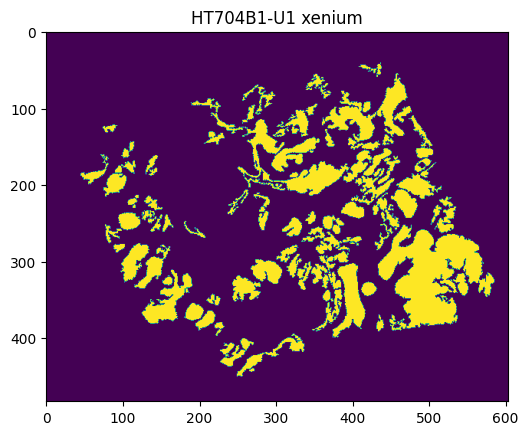

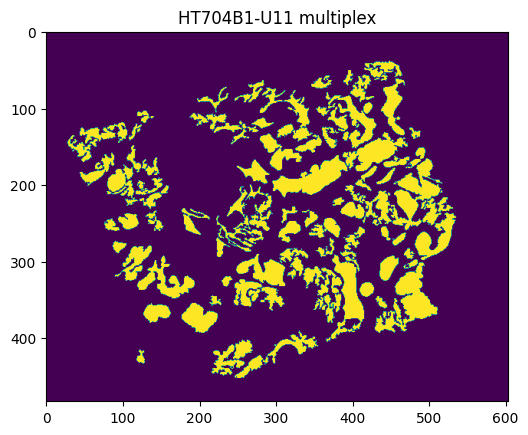

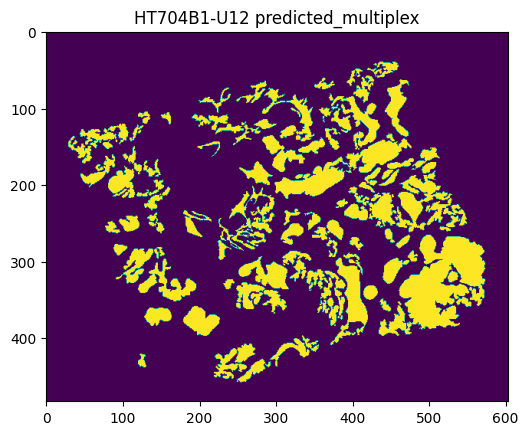

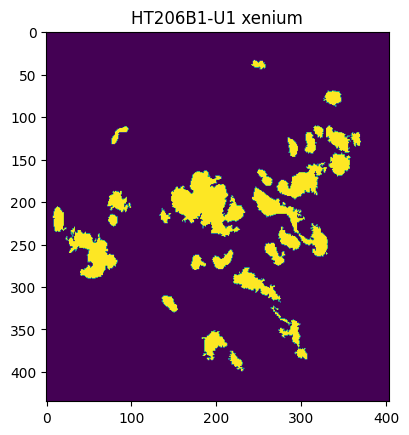

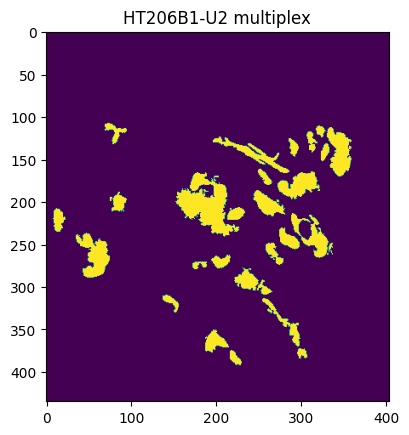

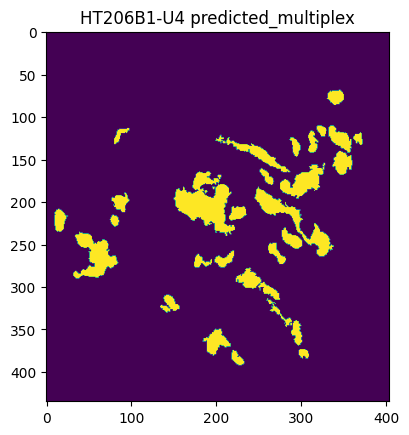

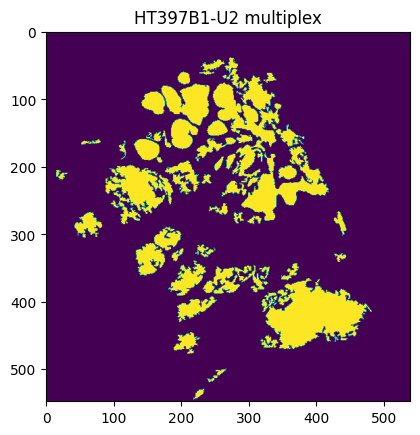

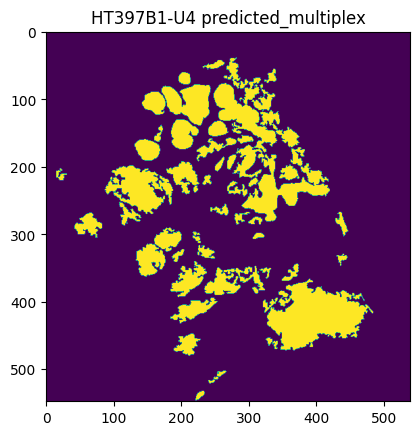

In [26]:
for case, data in case_to_data.items():
    sid_to_dcis_labeled = data['sid_to_dcis_labeled']
    sid_to_dtype = data['sid_to_dtype']
    sid_order = data['sid_order']
    pool, sids = [], []
    for sid, dtype in sid_to_dtype.items():
        if dtype not in pool:
            sids.append(sid)
            pool.append(dtype)

    for sid in sids:
        labeled = sid_to_dcis_labeled[sid]
        plt.imshow(labeled > 0)
        plt.title(sid + ' ' + sid_to_dtype[sid])
        plt.show()


In [27]:
for case, data in case_to_data.items():
    sid_to_dcis_labeled = data['sid_to_dcis_labeled']
    sid_order = data['sid_order']
    
    masks = np.stack([sid_to_dcis_labeled[sid] > 0 for sid in sid_order])
    labeled_volume = skimage.morphology.label(masks)
    props = skimage.measure.regionprops(labeled_volume)
    
    data['labeled_volume'] = labeled_volume
    data['labeled_volume_props'] = props
    
    area_sorted = np.flip(np.argsort([p.area for p in props]))
    area_sorted = np.asarray([p.label for p in props])[area_sorted].tolist()
    data['labels_by_volume'] = area_sorted

In [28]:

for case, data in case_to_data.items():
    dcis_df = data['regions_dcis']
    labeled_volume = data['labeled_volume']
    sid_to_props = data['sid_to_props']
    region_df = data['regions']
    area_sorted = data['labels_by_volume']
    
    region_id_to_dcis_label = {}
    for i, row in dcis_df.iterrows():
        labeled = labeled_volume[row['section_index']]
        p = sid_to_props[row['sid']][row['label'] - 1]
        r1, c1, r2, c2 = p.bbox

        values = np.unique(labeled[r1:r2, c1:c2][p.image])

        assert len(values) == 1
        assert values[0] != 0
        value = values[0]

        region_id_to_dcis_label[i] = int(value)
    region_df['dcis_label'] = [region_id_to_dcis_label.get(x) for x in region_df.index.to_list()]
    region_df['dcis_area_rank'] = [x if pd.isnull(x) else area_sorted.index(x) for x in region_df['dcis_label']]
    
    

100


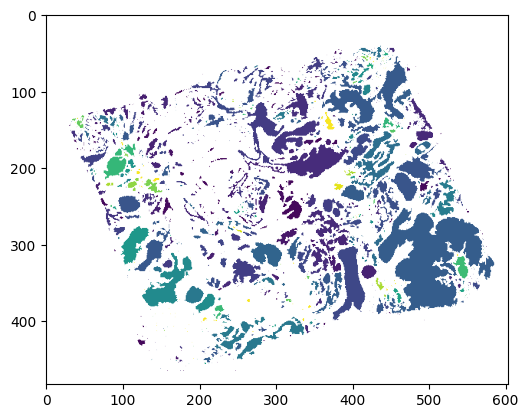

100


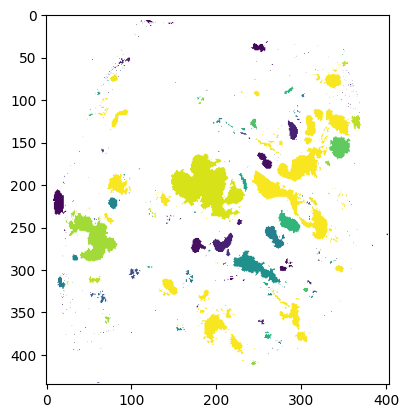

100


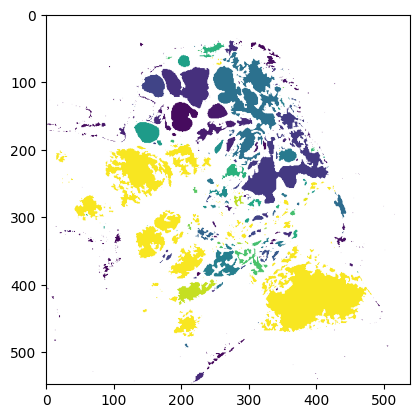

In [29]:
for case, data in case_to_data.items():
    sid_order = data['sid_order']
    sid_to_labeled = data['sid_to_labeled']
    region_df = data['regions']
    
    sid = sid_order[0]
    labeled = sid_to_labeled[sid]
    df = region_df[region_df['sid']==sid]
    rgba = helpers.to_cmapped_rgb(
        labeled, df, hue='immune_external_fraction', label_col='label',
        cmap='viridis', vmax=.2, borders=False)
    plt.imshow(rgba)
    plt.show()

In [30]:
# rgba = helpers.to_cmapped_rgb(
#     labeled, df, hue='dcis_label', label_col='label',
#     force_categorical=True, borders=False)
# plt.imshow(rgba)

In [31]:
# sid_to_position = {entry['sid']:entry['position'] for entry in config['sections']}
# rgba = helpers.to_stacked_rgb(
#     sid_order, sid_to_position, sid_to_labeled, region_df, hue='dcis_label',
#     spacing_scaler=10, squish_scaler=2, force_categorical=True,
# )
# plt.imshow(rgba)

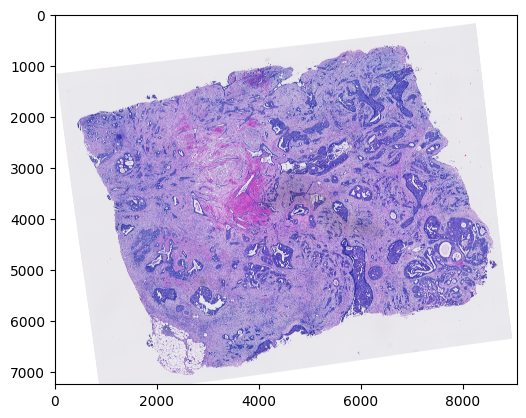

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


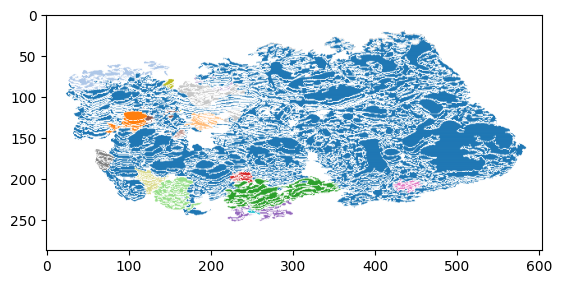

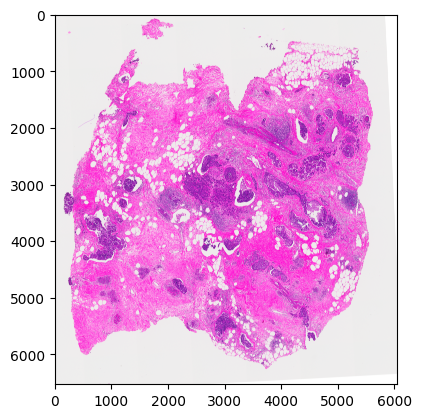

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


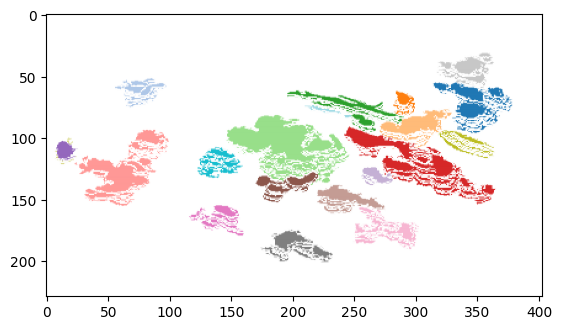

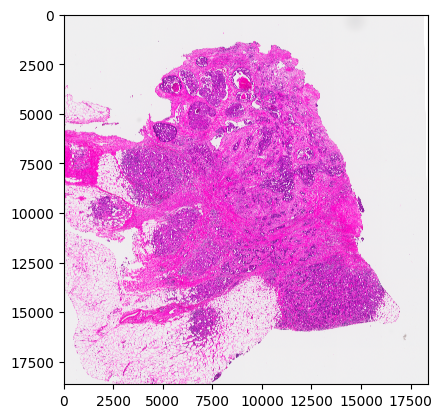

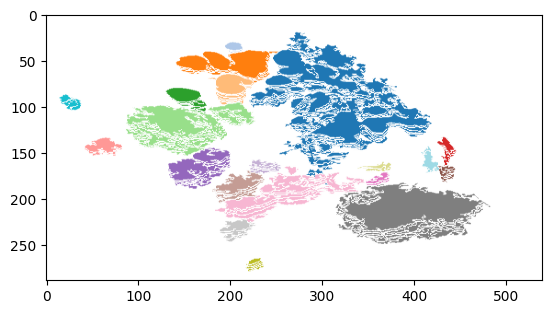

In [32]:
for case, data in case_to_data.items():
    sid_to_position = data['sid_to_position']
    region_df = data['regions']
    sid_to_labeled = data['sid_to_labeled']
    sid_order = data['sid_order']
    config = data['config']
    sid = sid_order[0]
    
    df = region_df[region_df['dcis_area_rank'] < 20]
    
    fp = [entry['data'][0]['filepath'] for entry in config['sections'] if 'he' in entry['data'][0]['dtype']][0]
    fp = fp.replace('/diskmnt/Projects/Users/', '/data/')
    plt.imshow(tifffile.imread(fp))
    plt.show()

    rgba = helpers.to_stacked_rgb(
        sid_order, sid_to_position, sid_to_labeled, df, hue='dcis_label',
        spacing_scaler=10, squish_scaler=2, force_categorical=True,
    )
    plt.imshow(rgba)
    plt.show()

In [33]:
scale_cols_regexs = [
    f'^{x}_.+_{y}$'
    for x in ['multiplex', 'predicted_multiplex', 'xenium']
    for y in ['region', 'boundary', 'external']
]

In [34]:
bins = np.linspace(0, 1, 20)
regions_combined = None
for case, data in case_to_data.items():
    df = data['regions'].copy()
    df['case'] = case
    df['myoepi_boundary_bin'] = np.digitize(df['myoepi_boundary_fraction'], bins)
    
    for c in df.columns:
        for rexp in scale_cols_regexs:
            if re.match(rexp, c):
                df[c] -= df[c].min()
                df[c] /= df[c].std()
                
                val = df[df['myoepi_boundary_bin']==1][c].mean()
                
                df[f'{c}_delta'] = df[c] - val
                break
    
    
    if regions_combined is None:
        regions_combined = df
    else:
        regions_combined = pd.concat((regions_combined, df))
regions_combined

/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{c}_delta'] = df[c] - val
/tmp/ipykernel_2854970/2270459809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

area   r1   r2   c1   c2  centroid_r  centroid_c  \
region_id                                                            
HT704B1-U1_0     153.0   37   64  404  442   48.934641  426.248366   
HT704B1-U1_1       1.0   40   49  424  433   44.000000  428.000000   
HT704B1-U1_2       3.0   40   51  440  450   45.000000  444.666667   
HT704B1-U1_3      33.0   40   54  442  459   46.303030  450.818182   
HT704B1-U1_4       2.0   42   51  377  387   46.000000  381.500000   
...                ...  ...  ...  ...  ...         ...         ...   
HT397B1-U31_642   23.0  526  540  222  236  532.652174  228.695652   
HT397B1-U31_643    1.0  531  540  190  199  535.000000  194.000000   
HT397B1-U31_644    1.0  532  541  123  132  536.000000  127.000000   
HT397B1-U31_645   22.0  539  547  146  161  545.318182  152.863636   
HT397B1-U31_646    9.0  540  547  160  172  545.888889  165.444444   

                 xenium_EPCAM_boundary  xenium_KRT5_boundary  \
region_id                                                      
HT704B1-U1_0                  2.534371              0.345915   
HT704B1-U1_1                  0.830708              0.333374   
HT704B1-U1_2                  0.352422              0.159110   
HT704B1-U1_3                  3.111611              1.333494   
HT704B1-U1_4                  0.538971              0.114597   
...                                ...                   ...   
HT397B1-U31_642                    NaN                   NaN   
HT397B1-U31_643                    NaN                   NaN   
HT397B1-U31_644                    NaN                   NaN   
HT397B1-U31_645                    NaN                   NaN   
HT397B1-U31_646                    NaN                   NaN   

                 xenium_PTPRC_boundary  ...  \
region_id                               ...   
HT704B1-U1_0                  1.050383  ...   
HT704B1-U1_1                  0.000000  ...   
HT704B1-U1_2                  0.570168  ...   
HT704B1-U1_3                  0.679483  ...   
HT704B1-U1_4                  0.328766  ...   
...                                ...  ...   
HT397B1-U31_642                    NaN  ...   
HT397B1-U31_643                    NaN  ...   
HT397B1-U31_644                    NaN  ...   
HT397B1-U31_645                    NaN  ...   
HT397B1-U31_646                    NaN  ...   

                 multiplex_Keratin 14_external_delta  \
region_id                                              
HT704B1-U1_0                                     NaN   
HT704B1-U1_1                                     NaN   
HT704B1-U1_2                                     NaN   
HT704B1-U1_3                                     NaN   
HT704B1-U1_4                                     NaN   
...                                              ...   
HT397B1-U31_642                            -0.000574   
HT397B1-U31_643                             0.012772   
HT397B1-U31_644                             0.012772   
HT397B1-U31_645                             0.006840   
HT397B1-U31_646                             0.006840   

                 multiplex_Podoplanin_external_delta  \
region_id                                              
HT704B1-U1_0                                     NaN   
HT704B1-U1_1                                     NaN   
HT704B1-U1_2                                     NaN   
HT704B1-U1_3                                     NaN   
HT704B1-U1_4                                     NaN   
...                                              ...   
HT397B1-U31_642                            -0.602650   
HT397B1-U31_643                            -0.602650   
HT397B1-U31_644                            -0.602650   
HT397B1-U31_645                            -0.602650   
HT397B1-U31_646                            -0.534572   

                 multiplex_SMA-(D)_external_delta  \
region_id                                           
HT704B1-U1_0                                  NaN   
HT704B1-U1_1                                 

In [54]:
tme_combined = None
for case, data in case_to_data.items():
    df = data['tme_distances']
    df['case'] = case
    
    for c in df.columns:
        if '_intensity' in c:
            val = df[df['distance_bin']==1][c].mean()

            df[f'{c}_delta'] = df[c] - val
    
    if tme_combined is None:
        tme_combined = df
    else:
        tme_combined = pd.concat((tme_combined, df))
tme_combined.index = np.arange(tme_combined.shape[0])
tme_combined

xenium_EPCAM_intensity  xenium_KRT5_intensity  \
0                           0.0               0.000000   
1                           0.0               0.000000   
2                           0.0               0.000000   
3                           0.0               0.562573   
4                           0.0               0.125016   
...                         ...                    ...   
4981043                     NaN                    NaN   
4981044                     NaN                    NaN   
4981045                     NaN                    NaN   
4981046                     NaN                    NaN   
4981047                     NaN                    NaN   

         xenium_PTPRC_intensity  xenium_CD4_intensity  xenium_CD8A_intensity  \
0                      1.060722                   0.0                    0.0   
1                      0.578576                   0.0                    0.0   
2                      0.000000                   0.0                    0.0   
3                      0.000000                   0.0                    0.0   
4                      0.000000                   0.0                    0.0   
...                         ...                   ...                    ...   
4981043                     NaN                   NaN                    NaN   
4981044                     NaN                   NaN                    NaN   
4981045                     NaN                   NaN                    NaN   
4981046                     NaN                   NaN                    NaN   
4981047                     NaN                   NaN                    NaN   

         xenium_MS4A1_intensity  xenium_CD68_intensity  \
0                           0.0                    0.0   
1                           0.0                    0.0   
2                           0.0                    0.0   
3                           0.0                    0.0   
4                           0.0                    0.0   
...                         ...                    ...   
4981043                     NaN                    NaN   
4981044                     NaN                    NaN   
4981045                     NaN                    NaN   
4981046                     NaN                    NaN   
4981047                     NaN                    NaN   

         xenium_CD163_intensity  xenium_ACTA2_intensity  \
0                           0.0                0.000000   
1                           0.0                0.000000   
2                           0.0                0.064957   
3                           0.0                1.039314   
4                           0.0                0.324786   
...                         ...                     ...   
4981043                     NaN                     NaN   
4981044                     NaN                     NaN   
4981045                     NaN                     NaN   
4981046                     NaN                     NaN   
4981047                     NaN                     NaN   

         xenium_PDPN_intensity  ...  predicted_multiplex_CD45 (D)_intensity  \
0                          0.0  ...                                     NaN   
1                          0.0  ...                                     NaN   
2                          0.0  ...                                     NaN   
3                          0.0  ...                                     NaN   
4                          0.0  ...                                     NaN   
...                        ...  ...                                     ...   
4981043                    NaN  ...                                     NaN   
4981044                    NaN  ...                                     NaN   
4981045                    NaN  ...                                     NaN   
4981046                    NaN  ...                                     NaN   
4981047                    NaN  ...                                     NaN 

In [20]:
case_to_data['HT206B1']['sid_to_tiled'].keys()

dict_keys(['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24', 'HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21', 'HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20'])

In [44]:
idx

3901526

In [49]:
# pct = .99
# idxs = np.argsort(tme_combined['distance'].values)
# idx = idxs[int(pct * len(idxs))]
# value = tme_combined['distance'][idx]
# value

In [56]:
f = tme_combined[tme_combined['distance'] < 100 / tiling_resolution] # less than 100 microns
f

xenium_EPCAM_intensity  xenium_KRT5_intensity  \
5                      0.045484               0.062508   
6                      0.227421               0.312540   
7                      0.000000               0.000000   
8                      0.000000               0.000000   
9                      0.000000               0.000000   
...                         ...                    ...   
4981025                     NaN                    NaN   
4981031                     NaN                    NaN   
4981032                     NaN                    NaN   
4981037                     NaN                    NaN   
4981038                     NaN                    NaN   

         xenium_PTPRC_intensity  xenium_CD4_intensity  xenium_CD8A_intensity  \
5                           0.0                   0.0                    0.0   
6                           0.0                   0.0                    0.0   
7                           0.0                   0.0                    0.0   
8                           0.0                   0.0                    0.0   
9                           0.0                   0.0                    0.0   
...                         ...                   ...                    ...   
4981025                     NaN                   NaN                    NaN   
4981031                     NaN                   NaN                    NaN   
4981032                     NaN                   NaN                    NaN   
4981037                     NaN                   NaN                    NaN   
4981038                     NaN                   NaN                    NaN   

         xenium_MS4A1_intensity  xenium_CD68_intensity  \
5                           0.0                    0.0   
6                           0.0                    0.0   
7                           0.0                    0.0   
8                           0.0                    0.0   
9                           0.0                    0.0   
...                         ...                    ...   
4981025                     NaN                    NaN   
4981031                     NaN                    NaN   
4981032                     NaN                    NaN   
4981037                     NaN                    NaN   
4981038                     NaN                    NaN   

         xenium_CD163_intensity  xenium_ACTA2_intensity  \
5                           0.0                0.064957   
6                           0.0                0.324786   
7                           0.0                0.000000   
8                           0.0                0.129914   
9                           0.0                0.129914   
...                         ...                     ...   
4981025                     NaN                     NaN   
4981031                     NaN                     NaN   
4981032                     NaN                     NaN   
4981037                     NaN                     NaN   
4981038                     NaN                     NaN   

         xenium_PDPN_intensity  ...  predicted_multiplex_CD45 (D)_intensity  \
5                     0.166703  ...                                     NaN   
6                     0.666812  ...                                     NaN   
7                     0.000000  ...                                     NaN   
8                     0.000000  ...                                     NaN   
9                     0.166703  ...                                     NaN   
...                        ...  ...                                     ...   
4981025                    NaN  ...                                     NaN   
4981031                    NaN  ...                                     NaN   
4981032                    NaN  ...                                     NaN   
4981037                    NaN  ...                                     NaN   
4981038                    NaN  ...                                     NaN 

<Axes: xlabel='distance_bin', ylabel='multiplex_CD8_intensity_delta'>

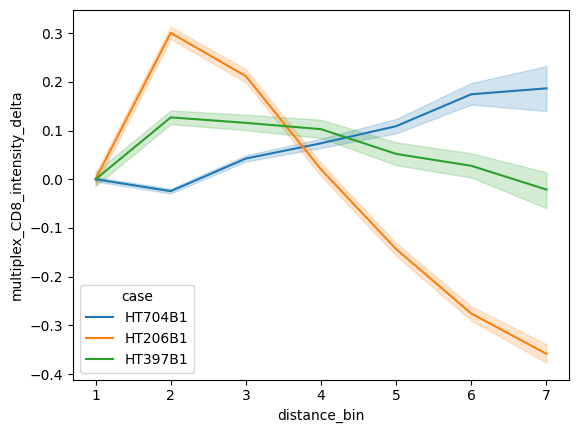

In [58]:
sns.lineplot(data=f, x='distance_bin', y='multiplex_CD8_intensity_delta', hue='case')

<Axes: xlabel='distance_bin', ylabel='xenium_CD68_intensity_delta'>

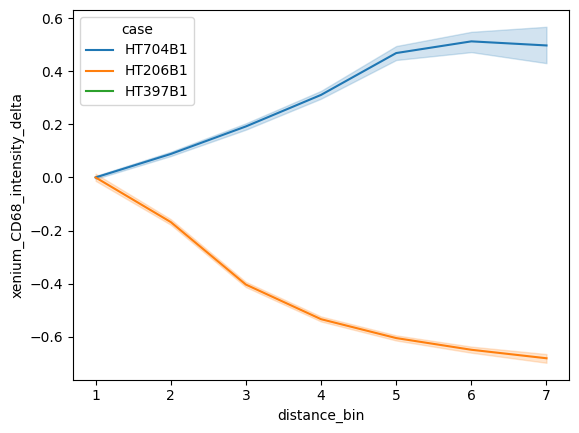

In [59]:
sns.lineplot(data=f, x='distance_bin', y='xenium_CD68_intensity_delta', hue='case')

<Axes: xlabel='distance_bin', ylabel='xenium_CD8A_intensity_delta'>

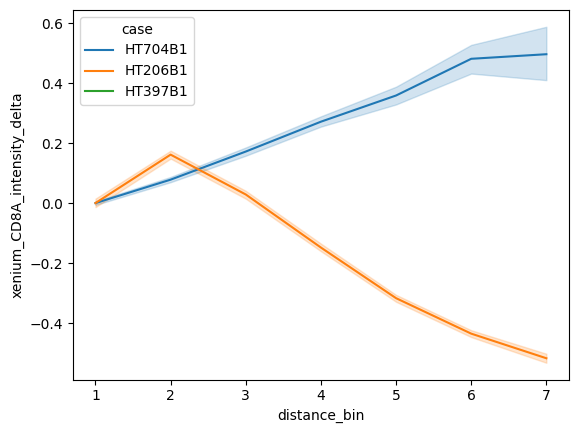

In [61]:
sns.lineplot(data=f, x='distance_bin', y='xenium_CD8A_intensity_delta', hue='case')

In [ ]:
def get_morphology_label(frac):
    if frac < .1:
        return 'IDC'
    if frac < .7:
        return 'partial IDC'
    return 'DCIS'
    
regions_combined['morphology_label'] = [get_morphology_label(x)
                                        for x in regions_combined['myoepi_boundary_fraction']]

In [ ]:
df = regions_combined[[True if x in ['xenium', 'multiplex'] else False for x in regions_combined['dtype']]]
df

In [ ]:
order = ['IDC', 'partial IDC', 'DCIS']

sns.boxplot(data=df, x='case', y='immune_external_fraction',hue='morphology_label', hue_order=order)

In [ ]:
sns.boxplot(data=df, x='case', y='xenium_CD8A_external',hue='morphology_label', hue_order=order, fliersize=0)
plt.ylim(-.5, 3.)

In [ ]:
sns.boxplot(data=df, x='case', y='xenium_CD8A_boundary',hue='morphology_label', hue_order=order, fliersize=0)
plt.ylim(-.5, 3.)

In [ ]:
sns.boxplot(data=df, x='case', y='multiplex_CD8_external',hue='morphology_label', hue_order=order, fliersize=0)
plt.ylim(-.5, 4.)

In [ ]:
sns.boxplot(data=df, x='case', y='multiplex_CD68_external',hue='morphology_label', hue_order=order, fliersize=0)
plt.ylim(-.5, 4.)

In [ ]:
sns.boxplot(data=df, x='case', y='xenium_CD68_external',hue='morphology_label', hue_order=order, fliersize=0)
plt.ylim(-.5, 5.)

In [ ]:
df['myoepi_boundary_bin'].min()

In [ ]:
bins = np.linspace(0, 1, 20)
df['myoepi_boundary_bin'] = np.digitize(df['myoepi_boundary_fraction'], bins)

In [ ]:
sns.boxplot(data=df, x='myoepi_boundary_bin', y='immune_external_fraction', hue='case', fliersize=0)

f = df[df['case']=='HT704B1']
sns.regplot(data=f, x='myoepi_boundary_bin', y='immune_external_fraction', order=2, scatter=False, )

In [ ]:
sns.boxplot(data=df, x='myoepi_boundary_bin', y='xenium_CD68_external', hue='case', fliersize=0, width=2.5, whis=False)

In [ ]:
sns.boxplot(data=df, x='myoepi_boundary_bin', y='multiplex_CD8_external', hue='case', fliersize=0, width=2.5, whis=False)

In [ ]:
sns.lineplot(data=df, x='myoepi_boundary_bin', y='multiplex_CD8_external', hue='case')





In [ ]:
# df['multiplex_CD8_external_delta'] = df['multiplex_CD8_external_delta'] - df[df['myoepi_boundary_bin']==1]['multiplex_CD8_external_delta'].min()
sns.lineplot(data=df, x='myoepi_boundary_bin', y='multiplex_CD8_external_delta', hue='case')
plt.axhline(0, c='gray')

In [ ]:
sns.scatterplot(data=df, x='myoepi_boundary_fraction', y='xenium_CD68_external', hue='case')

In [ ]:
f = df[df['case']=='HT704B1']
sns.regplot(data=f, x='myoepi_boundary_fraction', y='multiplex_CD8_external',
            x_bins=np.arange(0, 1, 100), order=2)

In [ ]:
f = df[df['case']=='HT206B1']
sns.regplot(data=f, x='myoepi_boundary_fraction', y='multiplex_CD8_external',
            x_bins=np.arange(0, 1, 100), order=2)

In [ ]:
f = df[df['case']=='HT397B1']
sns.regplot(data=f, x='myoepi_boundary_fraction', y='multiplex_CD8_external',
            x_bins=np.arange(0, 1, 100), order=2)